In [75]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

# Model Selection & Validation
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    RandomizedSearchCV, 
    GroupKFold, 
    TimeSeriesSplit
)

# Algorithms & Tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    precision_recall_curve, 
    average_precision_score,
    f1_score, 
    fbeta_score, 
    auc, 
    roc_curve, 
    roc_auc_score,
    log_loss
)

In [76]:
# Import Data
data = pd.read_csv("data/online_retail_II.csv")

In [77]:
# STEP 1: Data Loading & Preparation

# 1. Basic Cleaning
data = data.drop_duplicates()
data = data[data['Price'] > 0]
data = data.dropna(subset=['Customer ID'])
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# 2. Create NetRevenue
# Identify returns (Invoices starting with 'C')
data['IsReturn'] = data['Invoice'].astype(str).str.startswith('C')
# Calculate purchase amount (positive) and return amount (absolute value)
data['PurchaseAmount'] = np.where(data['IsReturn'] == False, data['Quantity'] * data['Price'], 0)
data['ReturnAmount'] = np.where(data['IsReturn'] == True,  (data['Quantity'] * data['Price']).abs(), 0)
# Define NetRevenue
data['NetRevenue'] = data['PurchaseAmount'] - data['ReturnAmount']

print(f"Data Prepared. Rows: {len(data)}")
print(f"Columns: {data.columns.tolist()}")

Data Prepared. Rows: 797815
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'IsReturn', 'PurchaseAmount', 'ReturnAmount', 'NetRevenue']


In [78]:
# STEP 2: FEATURE ENGINEERING & DATA GENERATION (FIXED COMPARISON)

def generate_features_at_cutoff(df_input, cutoff_date, target_window_days=180):
    
    # Use pre-cleaned data (NetRevenue must exist)
    df = df_input.copy()
    
    # Define history and future windows
    history = df[df['InvoiceDate'] <= cutoff_date].copy()
    future = df[(df['InvoiceDate'] > cutoff_date) & (df['InvoiceDate'] <= cutoff_date + pd.Timedelta(days=180))]
    
    snapshot_date = cutoff_date + pd.Timedelta(days=1)
    
    # 2. Base RFM Features
    features = history.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'Invoice': 'nunique',
        'NetRevenue': 'sum',
        'StockCode': 'nunique'
    })
    features.columns = ['Recency', 'Frequency', 'Monetary', 'Unique_Products']
    
    # We remove customers with Frequency == 1 because we cannot calculate their behavior patterns
    features = features[features['Frequency'] > 1]
    
    # Derived metrics
    features['Tenure'] = (snapshot_date - history.groupby('Customer ID')['InvoiceDate'].min()).dt.days
    features['AOV'] = features['Monetary'] / features['Frequency']
    features['Product_Variety_Score'] = features['Unique_Products'] / features['Frequency']
    
    # --- Behavior Trends (Last 90 days vs Previous 90 days) ---
    date_90 = cutoff_date - pd.Timedelta(days=90)
    recent = history[history['InvoiceDate'] > date_90]
    prev = history[(history['InvoiceDate'] <= date_90) & (history['InvoiceDate'] > (cutoff_date - pd.Timedelta(days=180)))]
    
    mon_trend = (recent.groupby('Customer ID')['NetRevenue'].sum() + 1) / (prev.groupby('Customer ID')['NetRevenue'].sum() + 1)
    freq_trend = (recent.groupby('Customer ID')['Invoice'].nunique() + 1) / (prev.groupby('Customer ID')['Invoice'].nunique() + 1)
    
    features = features.assign(Monetary_Trend=mon_trend, Frequency_Trend=freq_trend).fillna(0)

    # --- Returns & Geography ---
    returns = history[history['ReturnAmount'] > 0].groupby('Customer ID')['ReturnAmount'].count()
    total_tx = history.groupby('Customer ID')['Invoice'].count()
    features['Return_Rate'] = (returns / total_tx).fillna(0)
    features['IsUK'] = (history.groupby('Customer ID')['Country'].first() == 'United Kingdom').astype(int)

    # --- Gap Analysis ---
    tx_dates = history[['Customer ID', 'InvoiceDate']].drop_duplicates().sort_values(['Customer ID', 'InvoiceDate'])
    tx_dates['Days_Diff'] = tx_dates.groupby('Customer ID')['InvoiceDate'].diff().dt.days
    
    gap_stats = tx_dates.groupby('Customer ID')['Days_Diff'].agg(['mean', 'std'])
    features = features.join(gap_stats.rename(columns={'mean': 'Avg_Gap', 'std': 'Gap_Std'}), how='left')

    # Using last 3 gaps to see if the customer is "slowing down"
    last_3_gaps = tx_dates.groupby('Customer ID')['Days_Diff'].rolling(window=3).mean().groupby('Customer ID').last()
    features['Gap_Trend'] = (last_3_gaps / (features['Avg_Gap'] + 0.1)).fillna(1.0)
    
    features['Avg_Gap'] = features['Avg_Gap'].fillna(features['Recency'])
    features['Gap_Std'] = features['Gap_Std'].fillna(0)
    features['Latency_Risk'] = features['Recency'] / (features['Avg_Gap'] + 1)
    
    # --- Target: Dynamic Churn ---
    features['Dynamic_Threshold'] = (features['Avg_Gap'] + (3 * features['Gap_Std'])).clip(lower=30, upper=180)
    
    # Calculate days to next purchase
    last_purchase = history.groupby('Customer ID')['InvoiceDate'].max()
    next_purchase = future.groupby('Customer ID')['InvoiceDate'].min()
    days_to_next = (next_purchase - last_purchase).dt.days

    # Fix: Reindex days_to_next to match features index to prevent ValueError
    days_to_next = days_to_next.reindex(features.index)

    features['Churn'] = 0
    # Classify as churn if no future purchase or purchase exceeds dynamic threshold
    features.loc[days_to_next.isna(), 'Churn'] = 1
    features.loc[days_to_next > features['Dynamic_Threshold'], 'Churn'] = 1

    features['Cutoff_Date'] = cutoff_date
    return features.drop(['Dynamic_Threshold'], axis=1).replace([np.inf, -np.inf], 0).fillna(0)

# 2. Run Generation Loop
print("Starting data generation...")
cutoffs = [pd.Timestamp('2010-10-01'), pd.Timestamp('2011-01-01'), pd.Timestamp('2011-04-01'), pd.Timestamp('2011-06-01')]

full_panel_data = pd.concat([generate_features_at_cutoff(data, d, target_window_days=90) for d in cutoffs]).reset_index()

print(f"Dataset generated. Rows: {full_panel_data.shape[0]}")

Starting data generation...
Dataset generated. Rows: 12641


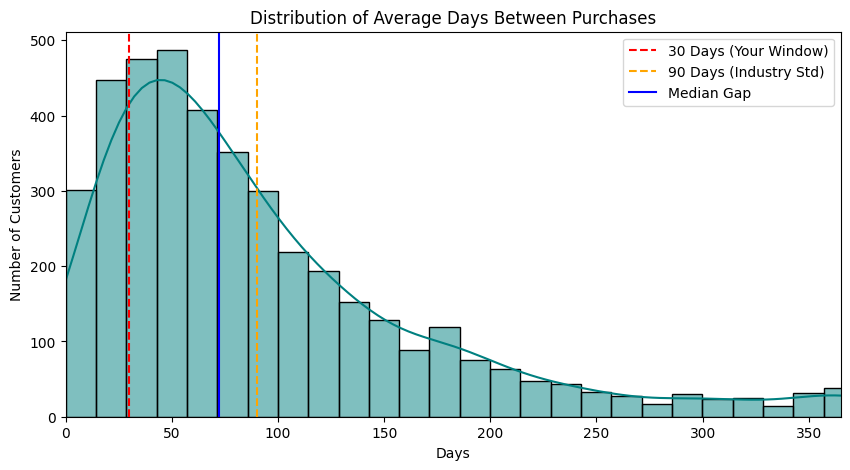

Returning Customers: 4256
Median Gap: 72.0 days
Customers with Gap > 30 days: 81.3%
Customers with Gap > 90 days: 39.6%


In [79]:
# STEP 3: Purchase Gap Analysis

try:
    # 1. Prepare Data
    # We use a clean copy and exclude returns (C-prefix) for valid gap calculation
    df_gaps = data[~data['Invoice'].astype(str).str.startswith('C')].copy()
    
    # 2. Calculate Days Between Purchases
    # Sort by customer and date, then calculate the difference
    tx_dates = df_gaps[['Customer ID', 'InvoiceDate']].drop_duplicates().sort_values(['Customer ID', 'InvoiceDate'])
    tx_dates['Days_Diff'] = tx_dates.groupby('Customer ID')['InvoiceDate'].diff().dt.days
    
    # Aggregate gaps per customer (exclude customers with only 1 purchase)
    gap_stats = tx_dates.groupby('Customer ID')['Days_Diff'].agg(['mean', 'count']).dropna()
    gap_stats.columns = ['Avg_Gap', 'Purchase_Count']

    # 3. Visualization
    plt.figure(figsize=(10, 5))
    sns.histplot(gap_stats['Avg_Gap'], bins=50, kde=True, color='teal')
    
    # Reference lines for churn thresholds
    plt.axvline(30, color='red', linestyle='--', label='30 Days (Your Window)')
    plt.axvline(90, color='orange', linestyle='--', label='90 Days (Industry Std)')
    plt.axvline(gap_stats['Avg_Gap'].median(), color='blue', label='Median Gap')
    
    plt.title('Distribution of Average Days Between Purchases')
    plt.xlabel('Days')
    plt.ylabel('Number of Customers')
    plt.xlim(0, 365) # Focus on the first year
    plt.legend()
    plt.show()

    # 4. Key Statistics Output
    print(f"Returning Customers: {len(gap_stats)}")
    print(f"Median Gap: {gap_stats['Avg_Gap'].median():.1f} days")
    print(f"Customers with Gap > 30 days: {(gap_stats['Avg_Gap'] > 30).mean():.1%}")
    print(f"Customers with Gap > 90 days: {(gap_stats['Avg_Gap'] > 90).mean():.1%}")

except Exception as e:
    print(f"Error in Gap Analysis: {e}")

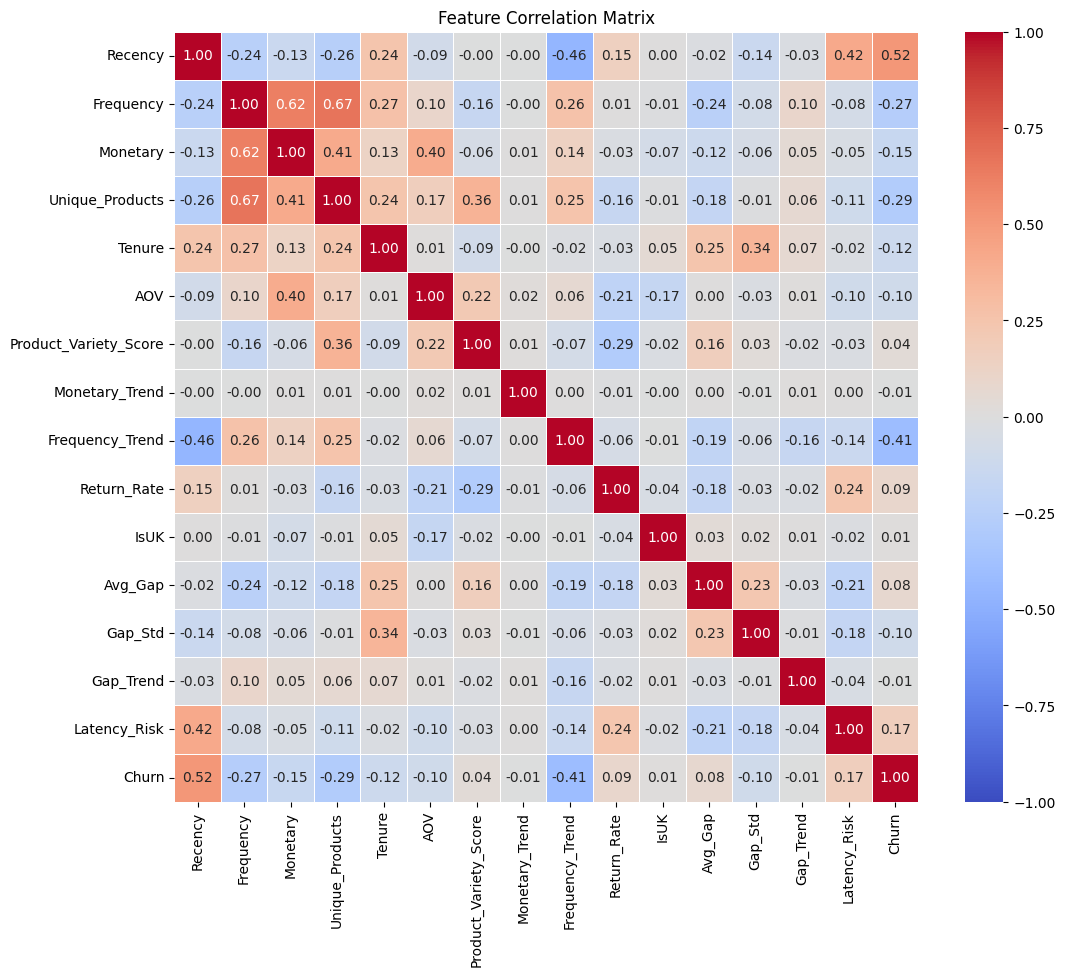


--- Feature Correlation with Churn ---
Churn                    1.000000
Recency                  0.515006
Latency_Risk             0.166140
Return_Rate              0.088120
Avg_Gap                  0.075850
Product_Variety_Score    0.035566
IsUK                     0.011918
Gap_Trend               -0.005194
Monetary_Trend          -0.007257
AOV                     -0.096260
Gap_Std                 -0.101560
Tenure                  -0.122247
Monetary                -0.151880
Frequency               -0.272183
Unique_Products         -0.287854
Frequency_Trend         -0.406885
Name: Churn, dtype: float64


In [80]:
# STEP 4: Feature Correlation Analysis

# 1. Prepare data for correlation
# Remove IDs and dates to keep only numerical features and target
cols_to_drop = ['Customer ID', 'Cutoff_Date']
corr_data = full_panel_data.drop(columns=[c for c in cols_to_drop if c in full_panel_data.columns])

# 2. Calculate Pearson correlation matrix
corr_matrix = corr_data.corr()

# 3. Visualize correlations using a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Show numerical values
    fmt=".2f",        # 2 decimal places
    cmap='coolwarm',  # Red for positive, Blue for negative
    vmin=-1, vmax=1,  # Correlation scale
    linewidths=0.5
)
plt.title('Feature Correlation Matrix')
plt.show()

# 4. Rank features by correlation with Churn
print("\n--- Feature Correlation with Churn ---")
print(corr_matrix['Churn'].sort_values(ascending=False))

In [81]:
# STEP 5: Time-Series Cross-Validation

# 0. Konfiguracja i Przygotowanie Danych
TARGET = "Churn"
TIME_COL = "Cutoff_Date"

if "full_panel_data" not in globals():
    raise NameError("Brak full_panel_data! Uruchom najpierw Step 2.")

df = full_panel_data.copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

# Ujednolicenie ID
if "CustomerID" in df.columns: ID_COL = "CustomerID"
elif "Customer ID" in df.columns: ID_COL = "Customer ID"
else: ID_COL = "index"

# Sortowanie dat
all_cutoffs = sorted(df[TIME_COL].unique())
test_cutoff = all_cutoffs[-1]  # Ostatnia data to Test (OOT)
train_cutoffs = [c for c in all_cutoffs if c < test_cutoff]

# Walidacja na 2 ostatnich okresach treningowych (żeby było szybko i stabilnie)
outer_val_cutoffs = train_cutoffs[-2:]

# Definicja Cech (wszystko co nie jest ID, Datą lub Targetem)
feature_cols = [c for c in df.columns if c not in {ID_COL, TIME_COL, TARGET}]

# Maski Train/Test (Kluczowe dla braku wycieku!)
train_mask = df[TIME_COL] < test_cutoff
test_mask  = df[TIME_COL] == test_cutoff

# Zbiory danych (X_train NIE zawiera danych z przyszłości!)
X_train = df.loc[train_mask, feature_cols]
y_train = df.loc[train_mask, TARGET].astype(int)
g_train = df.loc[train_mask, ID_COL]

X_test = df.loc[test_mask, feature_cols]
y_test = df.loc[test_mask, TARGET].astype(int)

print(f"RF Setup: Train Rows={len(X_train)} | Test Rows={len(X_test)}")
print(f"RF Validation Cutoffs: {[c.date() for c in outer_val_cutoffs]}")

# 1. Parametry (Dostosowane pod F1 i Churn)
# Zwiększyłem min_samples_leaf, żeby model był ogólniejszy
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [10, 20],      # Ważne! Chroni przed overfittingiem na klientach
    'class_weight': ['balanced', 'balanced_subsample']
}

# GroupKFold - klucz do uczciwego porównania z KNN/LR
inner_cv = GroupKFold(n_splits=3)

# 2. Walidacja Walk-Forward (Symulacja wdrożenia)
print("\n--- Rozpoczynam Walidację Walk-Forward (Metric: F1) ---")
outer_scores = []

for val_cutoff in outer_val_cutoffs:
    # Podział na przeszłość i "teraźniejszość" walidacyjną
    tr_idx = df.index[(df[TIME_COL] < val_cutoff)]
    val_idx = df.index[(df[TIME_COL] == val_cutoff)]
    
    X_tr, y_tr, g_tr = df.loc[tr_idx, feature_cols], df.loc[tr_idx, TARGET], df.loc[tr_idx, ID_COL]
    X_val, y_val = df.loc[val_idx, feature_cols], df.loc[val_idx, TARGET]
    
    # GridSearch z GroupKFold (uczciwy tuning)
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid,
        cv=inner_cv,
        scoring='f1',  # Twoja wybrana metryka
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_tr, y_tr, groups=g_tr)
    
    # Predykcja na walidacji
    # RF rzadko wymaga kalibracji do F1, ale dla spójności można ją dodać
    # Tutaj używamy czystego predyktora dla F1
    best_rf = grid.best_estimator_
    pred_val = best_rf.predict(X_val)
    f1 = f1_score(y_val, pred_val)
    
    outer_scores.append(f1)
    print(f"Val {val_cutoff.date()}: F1={f1:.4f} | Best Params: {grid.best_params_}")

print(f"\nŚrednie Validation F1: {np.mean(outer_scores):.4f}")

# 3. Finalny Trening i Test (Out-of-Time)
print("\n--- Trening Finalnego Modelu (na całym X_train) ---")
final_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=inner_cv,
    scoring='f1',
    n_jobs=-1
)
final_grid.fit(X_train, y_train, groups=g_train)
final_model = final_grid.best_estimator_

# Ewaluacja na zbiorze testowym (listopad 2011)
y_pred_test = final_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)

print("-" * 40)
print(f"FINAL RF TEST RESULT (Date: {test_cutoff.date()})")
print("-" * 40)
print(f"Test F1: {test_f1:.4f}")

RF Setup: Train Rows=9009 | Test Rows=3632
RF Validation Cutoffs: [datetime.date(2011, 1, 1), datetime.date(2011, 4, 1)]

--- Rozpoczynam Walidację Walk-Forward (Metric: F1) ---
Val 2011-01-01: F1=0.7467 | Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 20, 'n_estimators': 100}
Val 2011-04-01: F1=0.8845 | Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 500}

Średnie Validation F1: 0.8156

--- Trening Finalnego Modelu (na całym X_train) ---
----------------------------------------
FINAL RF TEST RESULT (Date: 2011-06-01)
----------------------------------------
Test F1: 0.8896


In [119]:
# STEP 6: Final Model Training (with Calibration)

# 1. Prxepare Full Training Data
# Use all historical snapshots to train the final version
print("Training final model on full dataset...")
feature_cols = [c for c in full_panel_data.columns if c not in {'CustomerID', 'Customer ID', 'Churn', 'Cutoff_Date', 'index'}]

X_final = full_panel_data.drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
y_final = full_panel_data['Churn']

# 2. Use Best Parameters from Step 5
# This grabs the optimized model settings automatically from your GridSearch
if 'grid' in locals():
    base_model = grid.best_estimator_
    print(f"✅ Using optimized settings: {grid.best_params_}")
else:
    # Safety fallback if Step 5 was skipped or interrupted
    print("⚠️ GridSearch not found. Using default balanced Random Forest.")
    base_model = RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42)

# 3. Initialize Probability Calibration
# 'isotonic' makes the model's confidence scores (probabilities) more accurate
# cv=5 ensures calibration is done via cross-validation
final_model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)

# 4. Fit Final Model
final_model.fit(X_final, y_final)

print("✅ Final Calibrated Model is trained and ready for segmentation.")

Training final model on full dataset...
✅ Using optimized settings: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 500}
✅ Final Calibrated Model is trained and ready for segmentation.


--- OUT-OF-TIME EVALUATION START ---

Generating Test Set for: 2011-09-01...
----------------------------------------
📊 OOT Results (Date: 2011-09-01)
    Accuracy: 83.94%
    Churn Rate: 66.29%
----------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1316
           1       0.88      0.88      0.88      2588

    accuracy                           0.84      3904
   macro avg       0.82      0.82      0.82      3904
weighted avg       0.84      0.84      0.84      3904



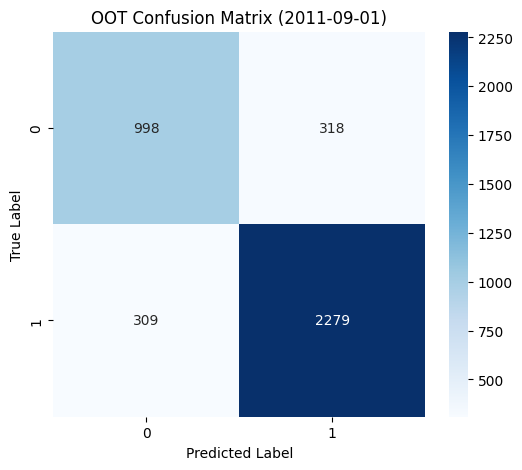

In [120]:
# STEP 7: Out-of-Time (OOT) Evaluation

print("--- OUT-OF-TIME EVALUATION START ---\n")

# 1. Generate OOT Test Set (November 2011)
test_date = pd.Timestamp('2011-09-01')
print(f"Generating Test Set for: {test_date.date()}...")

# Create features for the unseen test period
test_df = generate_features_at_cutoff(data, test_date, target_window_days=90).reset_index()
# 2. Prepare X and y
cols_to_drop = ['Churn', 'Customer ID', 'Cutoff_Date']
X_test = test_df.drop([c for c in cols_to_drop if c in test_df.columns], axis=1)
y_test = test_df['Churn']

# Clean data (handle Inf/NaN)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

# 3. Model Check & Prediction
if 'final_model' not in locals():
    print("⚠️ Model not found. Training quick fallback...")
    train_df = full_panel_data.reset_index() if 'Customer ID' not in full_panel_data.columns else full_panel_data
    X_train = train_df.drop([c for c in cols_to_drop if c in train_df.columns], axis=1).fillna(0)
    y_train = train_df['Churn']
    final_model = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced', random_state=42)
    final_model.fit(X_train, y_train)

# Get predictions and risk probabilities
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# 4. Display Performance Metrics
print("-" * 40)
print(f"📊 OOT Results (Date: {test_date.date()})")
print(f"    Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"    Churn Rate: {y_test.mean():.2%}")
print("-" * 40)
print(classification_report(y_test, y_pred))

# 5. Visualize Results (Confusion Matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'OOT Confusion Matrix ({test_date.date()})')
plt.show()

--- ADVANCED METRICS ANALYSIS ---

📊 TEST SET DIAGNOSTICS:
   Total Customers: 3904
   Total Churners (Class 1): 2588
   Actual Churn Rate (Baseline): 66.29%
------------------------------


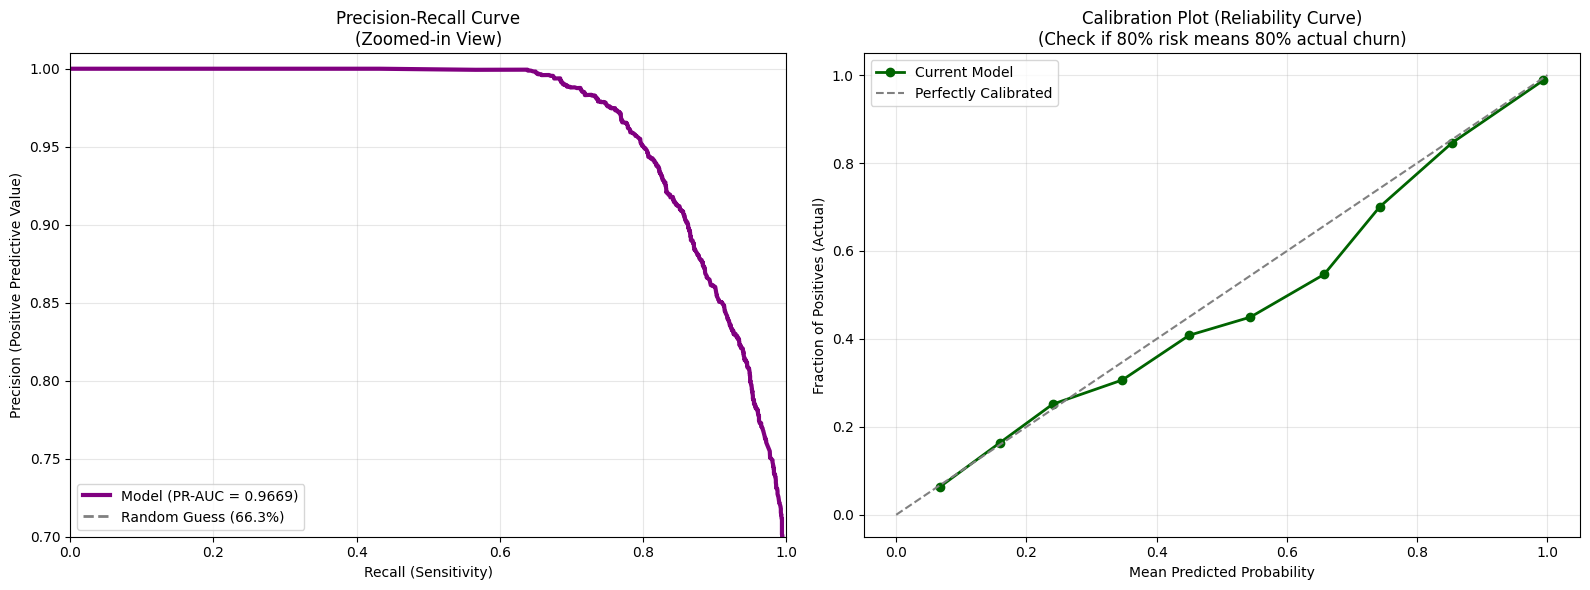

✅ Final PR-AUC: 0.9669
----------------------------------------


In [121]:
# STEP 8: Advanced Model Evaluation (PR-AUC & Calibration Plot)
print("--- ADVANCED METRICS ANALYSIS ---\n")

# 1. Dataset Diagnostics
# Calculate the actual churn rate in the test set (Baseline)
baseline_churn = y_test.mean()
print(f"📊 TEST SET DIAGNOSTICS:")
print(f"   Total Customers: {len(y_test)}")
print(f"   Total Churners (Class 1): {y_test.sum()}")
print(f"   Actual Churn Rate (Baseline): {baseline_churn:.2%}")
print("-" * 30)

# 2. Get Probabilities
# We use the calibrated model from Step 4
y_probs = final_model.predict_proba(X_test)[:, 1]

# 3. Calculate Curves
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

# Calibration Curve (Reliability Diagram)
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, strategy='uniform')

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- LEFT PLOT: Precision-Recall Curve ---
ax1.plot(recall, precision, label=f'Model (PR-AUC = {pr_auc:.4f})', color='purple', linewidth=3)

# Random Guess Line (Horizontal line at the level of Churn Rate)
ax1.axhline(y=baseline_churn, color='gray', linestyle='--', linewidth=2, label=f'Random Guess ({baseline_churn:.1%})')

ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision (Positive Predictive Value)')
ax1.set_title('Precision-Recall Curve\n(Zoomed-in View)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1.0])
ax1.set_ylim([0.7, 1.01])

# --- RIGHT PLOT: Calibration Plot ---
ax2.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Current Model', color='darkgreen')
ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

ax2.set_xlabel('Mean Predicted Probability')
ax2.set_ylabel('Fraction of Positives (Actual)')
ax2.set_title('Calibration Plot (Reliability Curve)\n(Check if 80% risk means 80% actual churn)')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Final PR-AUC: {pr_auc:.4f}")
print("-" * 40)

--- ANALYZE FEATURE IMPORTANCE ---
Training analyzer model...


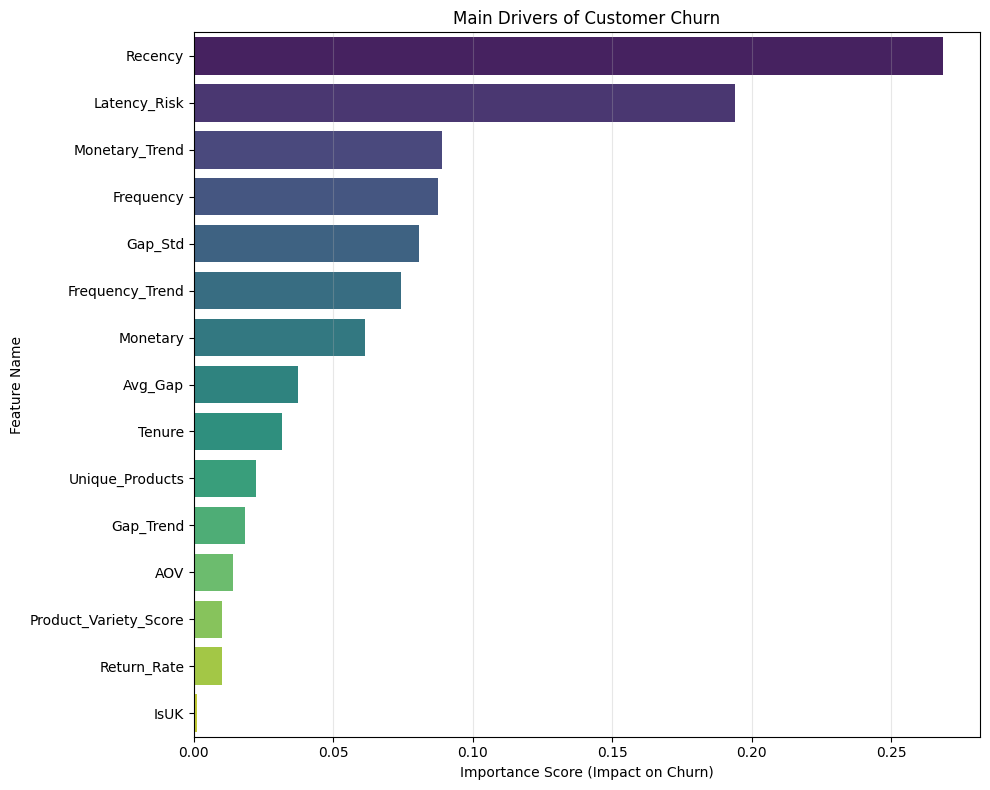


--- TOP 5 CHURN PREDICTORS ---
           Feature  Importance
0          Recency    0.268423
14    Latency_Risk    0.194032
7   Monetary_Trend    0.088999
1        Frequency    0.087612
12         Gap_Std    0.080565


In [122]:
# STEP 9: Feature Importance Analysis

print("--- ANALYZE FEATURE IMPORTANCE ---")

# 1. Prepare Data
# Ensure training data is available for analysis
if 'X_final' not in locals():
    X_final = full_panel_data.drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_final = full_panel_data['Churn']

# 2. Train Analyzer Model
# We use a standard Random Forest to extract clean importance scores
print("Training analyzer model...")
analyzer_rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=8, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)
analyzer_rf.fit(X_final, y_final)

# 3. Extract Importance Scores
importances = analyzer_rf.feature_importances_
feature_names = X_final.columns

# 4. Create Importance Ranking
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 5. Visualization
# Using a bar plot to show which features drive the churn prediction

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    hue='Feature',      
    data=feature_importance_df, 
    palette='viridis', 
    legend=False        
)

plt.xlabel('Importance Score (Impact on Churn)')
plt.ylabel('Feature Name')
plt.title('Main Drivers of Customer Churn')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Summary Output
print("\n--- TOP 5 CHURN PREDICTORS ---")
print(feature_importance_df.head(5))

In [123]:
# STEP 10: Segmentation with Fixed Business Rules

# 1. Get probabilities from the model
churn_probs = final_model.predict_proba(X_test)[:, 1]

# 2. Create Results Table
results = pd.DataFrame({
    'Actual_Status': y_test.values,
    'Churn_Risk': churn_probs
})
# Restore Customer ID as index
results.index = test_df['Customer ID']

# 3. Define Segments based on Rigid Rules
# These can be adjusted based on marketing capacity.
def get_segment_fixed(prob):
    # Rule 1: >80% is almost certainly churn (or already left)
    if prob >= 0.80:
        return '🔴 Critical'
    
    # Rule 2: 60-80% is our sweet spot for intervention
    elif prob >= 0.60:
        return '🟠 At Risk'
    
    # Rule 3: 40-60% is uncertain, keep an eye on them
    elif prob >= 0.40:
        return '🟡 Watchlist'
    
    # Rule 4: <40% is safe
    else:
        return '🟢 Safe'

results['Segment'] = results['Churn_Risk'].apply(get_segment_fixed)

# 4. Summary
print("\n--- FIXED SEGMENTATION SUMMARY ---")
print(results['Segment'].value_counts())

# 5. Top Candidates for Action
# We focus on the 'At Risk' group (60-80%) or Critical (>80%) depending on strategy
action_group = results[results['Segment'].isin(['🟠 At Risk', '🔴 Critical'])]
action_group = action_group.sort_values('Churn_Risk', ascending=False)

print(f"\n--- Customers requiring attention: {len(action_group)} ---")
if not action_group.empty:
    display(action_group.head(10))


--- FIXED SEGMENTATION SUMMARY ---
Segment
🔴 Critical     1954
🟢 Safe         1013
🟡 Watchlist     492
🟠 At Risk       445
Name: count, dtype: int64

--- Customers requiring attention: 2399 ---


,Actual_Status,Churn_Risk,Segment
Customer ID,,,
15392.0,1,1.0,🔴 Critical
16465.0,1,1.0,🔴 Critical
14471.0,1,1.0,🔴 Critical
14470.0,1,1.0,🔴 Critical
14469.0,1,1.0,🔴 Critical
16468.0,1,1.0,🔴 Critical
16472.0,1,1.0,🔴 Critical
14464.0,1,1.0,🔴 Critical
16476.0,1,1.0,🔴 Critical


In [124]:
# STEP 11: Financial Impact Analysis (Fixed Logic)

# 1. Prepare Financial Data
# aligning them with our prediction results
X_test_financial = test_df.set_index('Customer ID').loc[results.index].copy()

# 2. Calculate Annual Potential (Safe Extrapolation)
# Base calculation: Average Daily Spend * 365
daily_spend = X_test_financial['Monetary'] / (X_test_financial['Tenure'] + 1)
projected_annual = daily_spend * 365
X_test_financial['Annual_Potential'] = np.minimum(projected_annual, X_test_financial['Monetary'] * 3)

# 3. Merge with Segmentation Results
financial_report = results.join(X_test_financial[['Annual_Potential']], how='left')

# 4. Group by Segment
risk_report = financial_report.groupby('Segment')['Annual_Potential'].sum().sort_values(ascending=False)

# 5. Print Business Report
print("-" * 50)
print("💰 ESTIMATED ANNUAL REVENUE AT RISK (Nov 2011)")
print("-" * 50)

for segment, amount in risk_report.items():
    print(f"{segment.ljust(35)} : £ {amount:,.2f}")

print("-" * 50)

# Calculate Total "At Risk" Value
# Summing up High Risk and Priority segments
total_risk_val = risk_report.get('🟠 At Risk', 0) + \
                 risk_report.get('🟡 Watchlist', 0)

print(f"Total Revenue requiring immediate protection: £ {total_risk_val:,.2f}")
print("-" * 50)

--------------------------------------------------
💰 ESTIMATED ANNUAL REVENUE AT RISK (Nov 2011)
--------------------------------------------------
🟢 Safe                              : £ 5,194,602.66
🔴 Critical                          : £ 1,923,388.19
🟡 Watchlist                         : £ 1,323,841.26
🟠 At Risk                           : £ 603,055.16
--------------------------------------------------
Total Revenue requiring immediate protection: £ 1,926,896.42
--------------------------------------------------


In [125]:
# STEP 12: KNN - Data Cleaning

# 1) Data Input Validation
if "full_panel_data" not in globals():
    raise NameError("Required variable 'full_panel_data' not found. Please run Step 2 first.")

model_data = full_panel_data.copy()

# 2) Column Standardization
if "Customer ID" in model_data.columns:
    model_data = model_data.rename(columns={"Customer ID": "CustomerID"})
elif "CustomerID" not in model_data.columns and "index" in model_data.columns:
    model_data = model_data.rename(columns={"index": "CustomerID"})

if "CustomerID" not in model_data.columns:
    raise KeyError(f"Customer identifier column not found. Available: {model_data.columns.tolist()}")

# 3) Target and Date Formatting
if "Cutoff_Date" not in model_data.columns:
    raise KeyError("Column 'Cutoff_Date' missing in model_data.")
model_data["Cutoff_Date"] = pd.to_datetime(model_data["Cutoff_Date"])

if "Churn" not in model_data.columns:
    raise KeyError("Column 'Churn' missing in model_data.")
model_data["Churn"] = model_data["Churn"].astype(int)

# 4) Feature Selection
exclude_cols = {"CustomerID", "Churn", "Cutoff_Date"}
feature_cols = [c for c in model_data.columns if c not in exclude_cols]

if len(feature_cols) == 0:
    raise ValueError("No feature columns identified. Check model_data structure.")

# 5) Time-Based Split (Last cutoff as OOT Test)
all_cutoffs = sorted(model_data["Cutoff_Date"].unique())
if len(all_cutoffs) < 2:
    raise ValueError(f"Insufficient snapshots ({len(all_cutoffs)}). Minimum 2 required.")

test_cutoff = all_cutoffs[-1]
train_mask = model_data["Cutoff_Date"] < test_cutoff
test_mask  = model_data["Cutoff_Date"] == test_cutoff

X_train = model_data.loc[train_mask, feature_cols]
y_train = model_data.loc[train_mask, "Churn"]
groups_train = model_data.loc[train_mask, "CustomerID"]

X_test = model_data.loc[test_mask, feature_cols]
y_test = model_data.loc[test_mask, "Churn"]

# 6) Final Status Report
print("-" * 40)
print("✅ VARIABLES PREPARED FOR MODELING")
print("-" * 40)
print(f"Dataset Shape:  {model_data.shape}")
print(f"Features Count: {len(feature_cols)}")
print(f"Train Records:  {X_train.shape[0]} (Cutoffs: {[d.date().isoformat() for d in all_cutoffs[:-1]]})")
print(f"Test Records:   {X_test.shape[0]} (Cutoff: {test_cutoff.date().isoformat()})")
print(f"Unique Users:   {groups_train.nunique()} (in Train)")
print("-" * 40)

----------------------------------------
✅ VARIABLES PREPARED FOR MODELING
----------------------------------------
Dataset Shape:  (12641, 18)
Features Count: 15
Train Records:  9009 (Cutoffs: ['2010-10-01', '2011-01-01', '2011-04-01'])
Test Records:   3632 (Cutoff: 2011-06-01)
Unique Users:   3402 (in Train)
----------------------------------------


In [126]:
# STEP 13: KNN Model (Full History Training & OOT Test)

# 1. Setup Data (Aligning with Random Forest approach)
# We use the full history (up to June) for training
# We use the OOT set (Autumn) for testing
if 'test_df' not in globals():
    raise NameError("Run Step 7 first to generate 'test_df'!")

# Define columns (exclude ID and dates)
feature_cols = [c for c in full_panel_data.columns if c not in {'CustomerID', 'Customer ID', 'Churn', 'Cutoff_Date', 'index'}]

# Prepare Training Data (Full History)
X_train = full_panel_data[feature_cols].fillna(0)
y_train = full_panel_data['Churn'].astype(int)
# Grouping by CustomerID is crucial for validation
g_train = full_panel_data['CustomerID'] if 'CustomerID' in full_panel_data.columns else full_panel_data['Customer ID']

# Prepare Test Data (OOT / Autumn)
X_test = test_df[feature_cols].fillna(0)
y_test = test_df['Churn'].astype(int)

print(f"KNN Aligned Setup: Train Rows={len(X_train)} | Test Rows={len(X_test)}")

# 2. Pipeline Configuration
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_dist = {
    "knn__n_neighbors": randint(30, 100),
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["manhattan", "euclidean"],
    "knn__leaf_size": randint(20, 50)
}

# 3. Validation Strategy (Check stability on Apr/Jun)
inner_cv = GroupKFold(n_splits=5)
validation_cutoffs = sorted(full_panel_data['Cutoff_Date'].unique())[-2:]

print(f"Validating on: {[c.date() for c in validation_cutoffs]}")

for val_date in validation_cutoffs:
    # Split historical data for validation simulation
    mask_tr = full_panel_data['Cutoff_Date'] < val_date
    mask_val = full_panel_data['Cutoff_Date'] == val_date
    
    X_tr = full_panel_data.loc[mask_tr, feature_cols].fillna(0)
    y_tr = full_panel_data.loc[mask_tr, 'Churn'].astype(int)
    g_tr = g_train[mask_tr]
    
    X_val = full_panel_data.loc[mask_val, feature_cols].fillna(0)
    y_val = full_panel_data.loc[mask_val, 'Churn'].astype(int)
    
    # Run Search
    search = RandomizedSearchCV(
        knn_pipeline, param_dist, n_iter=15, cv=inner_cv, 
        scoring="average_precision", n_jobs=-1, random_state=42, verbose=0
    )
    search.fit(X_tr, y_tr, groups=g_tr)
    
    # Check score
    val_score = search.score(X_val, y_val)
    print(f"Val {val_date.date()}: AP={val_score:.4f}")

# 4. Final Training & OOT Test
print("\n--- Final Training on Full History ---")
final_knn_search = RandomizedSearchCV(
    knn_pipeline, param_dist, n_iter=30, cv=inner_cv, 
    scoring="average_precision", n_jobs=-1, random_state=42
)
final_knn_search.fit(X_train, y_train, groups=g_train)
best_knn = final_knn_search.best_estimator_

# Predict on OOT
test_probs = best_knn.predict_proba(X_test)[:, 1]
test_ap = average_precision_score(y_test, test_probs)

print("-" * 40)
print(f"FINAL KNN RESULT (OOT): AP={test_ap:.4f}")
print("-" * 40)

KNN Aligned Setup: Train Rows=12641 | Test Rows=3904
Validating on: [datetime.date(2011, 4, 1), datetime.date(2011, 6, 1)]
Val 2011-04-01: AP=0.9601
Val 2011-06-01: AP=0.9644

--- Final Training on Full History ---
----------------------------------------
FINAL KNN RESULT (OOT): AP=0.9614
----------------------------------------


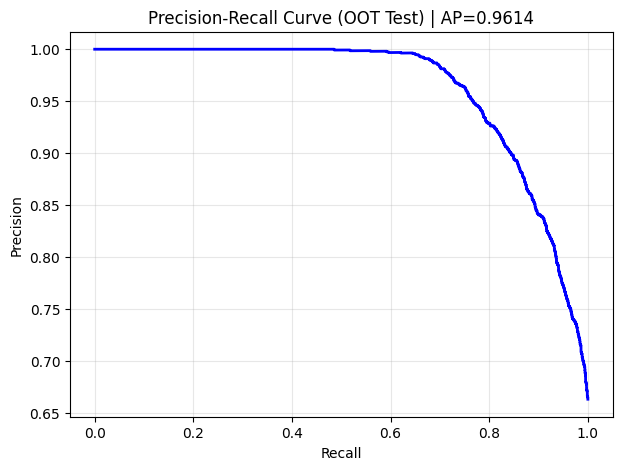

OOT Average Precision (AP): 0.9614
Optimal F1 Threshold: 0.5969 | Max F1: 0.8741


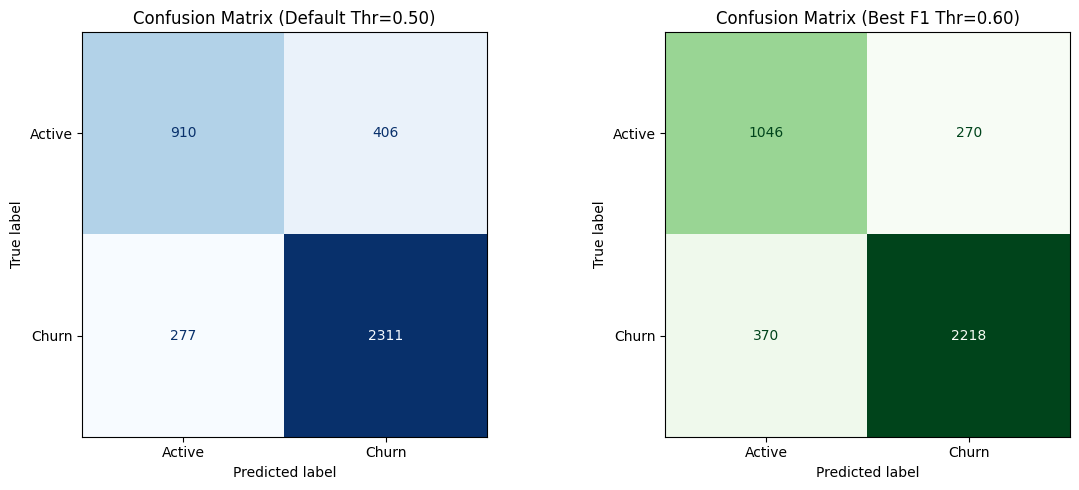

In [128]:
# STEP 14: Final Evaluation (PR Curve & Confusion Matrix)

# --- Safety check: Ensure test data exists from the last cutoff ---
if "X_test" not in globals() or "y_test" not in globals():
    all_cutoffs = sorted(model_data["Cutoff_Date"].unique())
    test_cutoff = all_cutoffs[-1]
    test_mask = model_data["Cutoff_Date"] == test_cutoff
    X_test = model_data.loc[test_mask, feature_cols]
    y_test = model_data.loc[test_mask, "Churn"].astype(int)

# --- Generate probability predictions ---
test_proba = best_knn.predict_proba(X_test)[:, 1]

# --- Calculate and plot Precision-Recall curve ---
precision, recall, thresholds = precision_recall_curve(y_test, test_proba)
ap = average_precision_score(y_test, test_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (OOT Test) | AP={ap:.4f}")
plt.grid(True, alpha=0.3)
plt.show()

# --- Threshold Optimization (Best F1 Score) ---
# Calculate F1 for each threshold found in PR curve
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_thr = thresholds[best_idx - 1] if 0 < best_idx < len(thresholds) else 0.5

# --- Generate predictions based on 0.5 vs Optimized threshold ---
y_pred_05 = (test_proba >= 0.5).astype(int)
y_pred_best = (test_proba >= best_thr).astype(int)

print(f"OOT Average Precision (AP): {ap:.4f}")
print(f"Optimal F1 Threshold: {best_thr:.4f} | Max F1: {f1_scores[best_idx]:.4f}")

# --- Plot Confusion Matrices ---
cm05 = confusion_matrix(y_test, y_pred_05)
cmb  = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Default 0.5 threshold
ConfusionMatrixDisplay(cm05, display_labels=["Active", "Churn"]).plot(ax=axes[0], values_format="d", colorbar=False, cmap='Blues')
axes[0].set_title("Confusion Matrix (Default Thr=0.50)")

# Optimized threshold
ConfusionMatrixDisplay(cmb, display_labels=["Active", "Churn"]).plot(ax=axes[1], values_format="d", colorbar=False, cmap='Greens')
axes[1].set_title(f"Confusion Matrix (Best F1 Thr={best_thr:.2f})")

plt.tight_layout()
plt.show()

In [129]:
# STEP 15: Logistic Regression (Full History Training & OOT Test)

# 1. Reuse Data Setup from KNN step (for consistency)
# X_train, y_train, X_test, y_test are already set correctly above
print(f"LR Aligned Setup: Train Rows={len(X_train)} | Test Rows={len(X_test)}")

# 2. Pipeline Configuration
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000))
])

param_dist_lr = {
    "lr__C": loguniform(0.01, 10),
    "lr__class_weight": [None, "balanced"]
}

# 3. Validation Strategy
print(f"Validating on: {[c.date() for c in validation_cutoffs]}")

for val_date in validation_cutoffs:
    # Split historical data
    mask_tr = full_panel_data['Cutoff_Date'] < val_date
    mask_val = full_panel_data['Cutoff_Date'] == val_date
    
    X_tr = full_panel_data.loc[mask_tr, feature_cols].fillna(0)
    y_tr = full_panel_data.loc[mask_tr, 'Churn'].astype(int)
    g_tr = g_train[mask_tr]
    
    X_val = full_panel_data.loc[mask_val, feature_cols].fillna(0)
    y_val = full_panel_data.loc[mask_val, 'Churn'].astype(int)
    
    # Tuning
    search = RandomizedSearchCV(
        lr_pipeline, param_dist_lr, n_iter=15, cv=inner_cv, 
        scoring="average_precision", n_jobs=-1, random_state=42, verbose=0
    )
    search.fit(X_tr, y_tr, groups=g_tr)
    
    # Calibration check during validation
    cal = CalibratedClassifierCV(search.best_estimator_, method='sigmoid', cv=StratifiedKFold(3))
    cal.fit(X_tr, y_tr)
    
    val_probs = cal.predict_proba(X_val)[:, 1]
    val_ap = average_precision_score(y_val, val_probs)
    print(f"Val {val_date.date()}: AP={val_ap:.4f}")

# 4. Final Training & OOT Test
print("\n--- Final Training on Full History ---")
final_lr_search = RandomizedSearchCV(
    lr_pipeline, param_dist_lr, n_iter=30, cv=inner_cv, 
    scoring="average_precision", n_jobs=-1, random_state=42
)
final_lr_search.fit(X_train, y_train, groups=g_train)

# Final Calibration on Full Data
final_lr_cal = CalibratedClassifierCV(final_lr_search.best_estimator_, method='sigmoid', cv=StratifiedKFold(5))
final_lr_cal.fit(X_train, y_train)

# Predict on OOT
test_probs_lr = final_lr_cal.predict_proba(X_test)[:, 1]
test_ap_lr = average_precision_score(y_test, test_probs_lr)

print("-" * 40)
print(f"FINAL LR RESULT (OOT): AP={test_ap_lr:.4f}")
print("-" * 40)

LR Aligned Setup: Train Rows=12641 | Test Rows=3904
Validating on: [datetime.date(2011, 4, 1), datetime.date(2011, 6, 1)]
Val 2011-04-01: AP=0.9623
Val 2011-06-01: AP=0.9677

--- Final Training on Full History ---
----------------------------------------
FINAL LR RESULT (OOT): AP=0.9611
----------------------------------------
